# BGSE Summer School, July 2021: Topic modeling and LDA

Today we take a look at topic modeling, a thriving branch of unsupervised generative NLP which is used to represent text documents as a distribution over categories of important underlying information. Let us import some libraries and immediately tackle the specifics of LDA.

## Import libraries

In [1]:
# Basics
import re                                                              
import os                                                              
from pathlib import Path
import numpy as np
import pandas as pd

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt                                        
import matplotlib.animation as animation
plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Misc
from tqdm import tqdm                                                 
tqdm.pandas()
import scipy.stats as stats

In [2]:
# reproducibility
seed = 42
# python RNG
import random
random.seed(seed)
# numpy RNG
import numpy as np
np.random.seed(seed)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

## Topic modeling with Latent Dirichlet Allocation

The key idea with topic modeling is that documents exhibit each category (or topic) in some proportion, which we would like to learn from the data. Given that what we observe are words, it is further assumed that each topic is a distribution over words, and that using the latter we can estimate the former. As such, the objective of topic modeling is to estimate the topic-document distribution and the word-topic distribution using Bayesian inference techniques in order to find the latent thematic structure in the text. The model thus aims to use the observed words to infer hidden topics.

Crucially, LDA places symmetric Dirichlet priors over the two distributions. [Intuitively](https://en.wikipedia.org/wiki/Dirichlet_distribution), these priors allow documents to contain few topics and topics to use only a handful of words frequently. The resulting Dirichlet distribution can be thought of as a distribution of distributions (a multinomial generalization of a Beta-distribution), which assigns word-to-topic and topic-to-document probabilities. In a sense, a Dirichlet distribution represents our uncertainty over the actual distribution of topics over documents and words over topics.

In plate notation, the graphical model of LDA is a three-level generative model that looks like this:

![plate](https://scikit-learn.org/stable/_images/lda_model_graph.png)

The parameters above can be described as:
- $D$ denotes the number of documents in our corpus-
- $K$ denotes the number of topics we exogenously chose for our data.
- $V$ refers to the vocabulary of words in our corpus.
- $N_d$ is the number of words a given document $d$ has.
- $w_{d,n}$ refers to each word in document $d$ and indexed in $N_d$ as $n$.
- $z_{d,n}$ is the topic assignment for word $n$ in document $d$, which is drawn from a multinomial distribution.
- $\theta_d$ is the topic distribution for document $d$, a probability vector or multinomial distribution over topics.
- $\beta_k$ is the word distribution for topic $k$, a probability vector over words.

#### $\theta$ and $\beta$ in detail
$\theta$ is a random matrix where a $d,j$ cell represents the probability of the $d$ th document being assigned to a topic $j$ (naturally, the sum of probabilities for document $d$ is one). Since the topic assignment is drawn from a multinomial distribution $z_{d,n}$, $\theta$ can be interpreted as a distribution over multinomial distributions. Bayesian tractability of these underlying multinomial distributions encourage the use of Dirichlet distributions to model $\theta$ and $\beta$ themselves, since these are _conjugate priors_ for the multinomial distribution. This means that if the prior distirbution of the multinomial parameters is Dirichlet, then the posterior distribution is also a Dirichlet distribution, with updated parameters. The benefit of this is that the posterior distribution is easy to compute, and that we can get an idea of how our beliefs update when collecting additional data. 

#### Dirichlet Distributions
A Dirichlet distribution is thus a conjugate prior for $p_1, ... p_k$ probabilities and $\alpha_1, ... \alpha_k$ hyperparameters, typically referred to as concentration parameters. To understand why, note that for a higher value for a given $\alpha_i$, a Dirichlet will assign a greater amount of mass to the probability of observing $x_i$. Higher $\alpha$ values for all possible observations attracts $x_i$ toward some central value. Conversely, $\alpha_i<1$ can be thought of as an anti-weight that pushes away $x_i$ toward extremes. Numerically, this can be shown by drawing multiple samples from a $K=3$ Dirichlet distribution with varying $\alpha$ parameters.

<div style="text-align:center"><img src="figs/scatter.gif" width="250" align="center"></div>

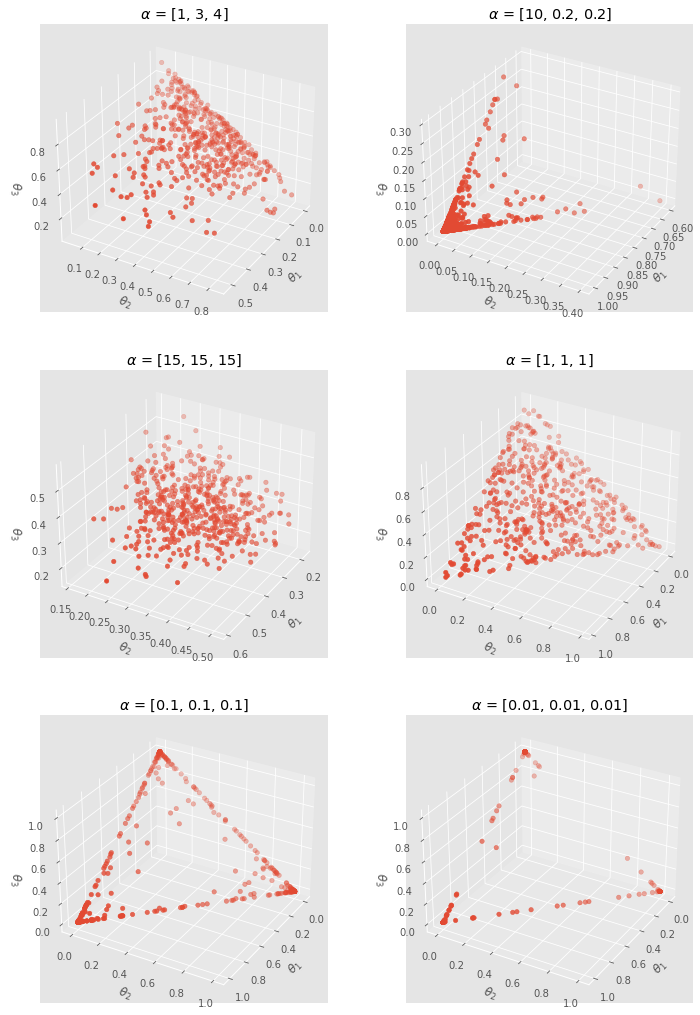

In [3]:
fig = plt.figure(figsize=(12,18))
alphas = [[1, 3, 4], [10, 0.2, 0.2], [15,15,15], [1, 1, 1], [0.1, 0.1, 0.1], [0.01, 0.01, 0.01]]
for i, tripl in enumerate(alphas):
    theta = stats.dirichlet(tripl).rvs(500)
    
    ax = fig.add_subplot(3, 2, i+1, projection='3d')
    ax = plt.gca(projection='3d')
    plt.title(r'$\alpha$ = {}'.format(tripl))
    ax.scatter(theta[:, 0], theta[:, 1], theta[:, 2])
    ax.view_init(azim=30)
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_zlabel(r'$\theta_3$')

The important thing to keep in mind is that the sparcity induced by modelling $\beta$ and $\theta$ as random variables drawn from Dirichlet processes with small $\alpha$ and $\eta$ will play an instrumental role in tightly clustering documents to topics ($\theta$) and topics to words ($\eta$). It penalizes documents that use many topics or topics represented by too many words. This is somewhat intuitive, as humans generally only need a handful of very specific terms to identify the topic of any document.

#### Back to the model
Numerically, let's consider an example:
<div style="text-align:center">
<img src="figs/LDA_mod.png" alt="LDA modified" style="height: 400px; width:800px;"/>
</div>

The model assumes the following generative process for a corpus with $D$ documents and $K$ topics.

1. For each topic $k \in K$, draw $\beta_k \sim Dirichlet(\eta)$. This provides a distribution over the words

2. For each document $d \in D$, draw the topic proportions $\theta_d \sim Dirichlet(\alpha)$

3. For each word $i$ in document $d$

    1. Draw the topic assignment $z_{di} \sim Multinomial(\theta_d)$
    
    2. Draw the observed word $w_{ij} \sim Multinomial(\beta_{z_{di}})$
    
Bayesian inference derives the posterior probability from two elements: a _prior probability_ and a _likelihood function_ derived from a statistical model of the observed data (here, words and documents). A key concern is, however, how to compute the posterior distribution of all these hidden variables given documents. 
    
A stylized posterior distribution reads: 
$$
p(z, \theta, \beta \mid w, \alpha, \eta)=\frac{p(z, \theta, \beta, w \mid \alpha, \eta)}{p(w \mid \alpha, \eta)}
$$

As in many other complex statistical models filled with latent variables, this posterior distribution is in practice intractable (this is due to the coupling between $\theta$ and $\beta$ in the summation over latent
topics), thus requiring of approximate inference.

### Approximate inference

Multiple methods of approximating the posterior exist in Bayesian statistics, with **Gibbs Sampling** and **variational inference** being traditionally applied the most. In what follows we mostly focus on the former, but present the latter briefly since in practice it's more easily implemented. For a complete review on variational inference methods, check [this paper](https://arxiv.org/pdf/1601.00670.pdf) by Blei and co-authors. For a non-LDA related introduction to Gibbs sampling, take a look [here](https://drum.lib.umd.edu/bitstream/handle/1903/10058/gsfu.pdf?sequence=3&isAllowed=y).

#### Variational inference

Variational inference seeks to approximate the intractable posterior with some well-known and well-behaved probability distribution that closely matches the true posterior. Using Kullback-Leibler divergence measures, the algorithm optimizes over a family of distributions and picks the member that best mimics the exact posterior, ie. 

$$
\gamma^{\star}, \phi^{\star}, \lambda^{\star}=\operatorname{argmin}_{(\gamma, \phi, \lambda)} D(q(\theta, \mathbf{z}, \beta \mid \gamma, \phi, \lambda) \| p(\theta, \mathbf{z}, \beta \mid \mathcal{D} ; \alpha, \eta)
$$

where $\gamma, \phi$ and $\lambda$ represent variational parameters used to approximate $\theta, z$ and $\beta$, respectively. The $D()$ function represents the KL divergence between a member distribution $q$ and the true posterior $p$. This method provides a locally-optimal exact-analytical solution to an approximation of the posterior distribution.

#### Gibbs Sampling

Gibbs Sampling is an alternative empirical method of approximating the posterior. A Monte Carlo Markov Chain method, the basic idea is to iteratetively compute the posterior of each of the latent variables by sampling from conditional distributions where all other latent variables are fixed and treated as known. Importantly, the variables used to condition are constantly updated on their most recent expected distributions, in the hopes that we gradually inch closer to the posterior joint distribution. 

<div style="text-align:center">
<img src="figs/gibbs.png" alt="LDA modified" style="width:600px;"/>
</div>

In more practical terms, we iterate over words in a document and we estimate the conditional probability distribution of the word's specific topic assignment given all other topic assignments. Mathematically, we will find the conditional probability distribution of a single word topic assignment conditioned on the rest of the model:

$$
p\left(z_{d, n}=k \mid \vec{z}_{-d, n}, \vec{w}, \alpha, \eta\right)=\frac{p\left(z_{d, n}=k, \vec{z}_{-d, n} \mid \vec{w}, \alpha, \eta\right)}{p\left(\vec{z}_{-d, n} \mid \vec{w}, \alpha, \eta\right)}
$$

We won't delve on the math, but note that due to the special structure of the LDA model we are able to integrate out both $\theta$ and $\beta$ in the equation above (in jargon, we are able to marginalize the target posterior over $\beta$ and $\theta$). This dramatically reduces the space in which we explore in the Gibbs Sampler, which is convenient since it will converge to a stationary posterior at a faster rate. The algorithm for this marginalized posterior is known as the **collapsed Gibbs Sampler**. After integrating out, the conditional probability distribution reads:

$$
p\left(z_{d, n}=k \mid \vec{z}_{-d, n}, \vec{w}, \alpha, \eta\right)=\frac{n_{d, k}+\alpha_{k}}{\sum_{i}^{K} \left(n_{d, i}+\alpha_{i}\right)} \frac{v_{k, w_{d, n}}+\eta_{w_{d, n}}}{\sum_{w \in V} \left(v_{k, i}+\eta_{i}\right)}
$$

There are two parts to the equation above. First part tells us how much each topic is present in a document, while the second part tells us a topic's affinity towards a word. Since this is a probability distribution, for each word we will get a vector of probabilities. After this probability is computed, we sample a new $z$ assignment for the word. In pseudo-code, this reads:
<ol>
  <li>Decrement $n_{d, z_{old}}$ and $v_{w_{d,n}, z_{old}}$</li>
  <li>Sample $z_{new}=k$ with probability proportional to $p\left(z_{d, n}=k \mid \vec{z}_{-d, n}, \vec{w}, \alpha, \eta\right)$</li>
  <li>Increment $n_{d, z_{new}}$ and $v_{w_{d,n}, z_{new}}$</li>
</ol>
    

After sampling **$z \mid w$** with Gibbs sampling, one can recover $\theta$ and $\beta$ with

$$
\begin{aligned}
&\hat{\beta}_{k, w_{n}}=\frac{n_{k, w_{n}}+\eta}{n_{K}+V \eta} \\
&\hat{\theta}_{d k}=\frac{n_{d k}+\alpha}{n_{d}+K \alpha}
\end{aligned}
$$

which are marginalized versions of the first and second term of the equation above.

#### Gibbs sampler example
It may be instructive to first present a quick example of a manually-built topic model where we use Gibbs sampler to sequentially update topic assignments to words. Other parts of this script will refrain from using this code (which is slightly simplified for speed following [this paper](https://www.ics.uci.edu/~asuncion/pubs/KDD_08.pdf)), and instead we will use off-the-shelve modules from well-known Python libraries. 

##### Visualize text

In [26]:
from termcolor import colored, cprint

def parse_text(text):
    ws = []
    for item in docs[text]:
        word = idx_voc[item]
        ws.append(word)
    f = list(zip(ws, z_d_n[text]))

    a_dict = {}
    for i in range(11):
        a_dict[i] = [x[0] for x in f if x[1] == i] 

    remove_punct = str.maketrans('','','!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’')
    h = (
        data_sample[text]
        .lower()
        .translate(remove_punct)
        .split()
    )
    
    word_join = [
        colored(x, 'grey') if x in a_dict[0] else 
        colored(x, 'red') if x in a_dict[1] else 
        colored(x, 'green') if x in a_dict[2] else 
        colored(x, 'yellow') if x in a_dict[3] else 
        colored(x, 'blue') if x in a_dict[4] else 
        colored(x, 'magenta') if x in a_dict[5] else 
        colored(x, 'cyan') if x in a_dict[6] else
        colored(x, 'cyan', 'on_grey') if x in a_dict[7] else
        colored(x, 'blue', 'on_yellow') if x in a_dict[8] else
        colored(x, 'cyan', 'on_green') if x in a_dict[9] else
        
        x for x in h
    ]

    print(' '.join(word_join))

In [27]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [41]:
n_ = 1000

# Fetch training data from sklearn
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=seed,
    remove=('headers', 'footers', 'quotes'),
    return_X_y=True,
)

data_sample = data[:n_]

In [42]:
# Define matrix
tf_vect = CountVectorizer(
    max_df=0.8, 
    min_df=2,
    max_features=10000,
    stop_words='english'
)
tf = tf_vect.fit_transform(data_sample)

In [43]:
voc = tf_vect.vocabulary_

idx_voc = tf_vect.get_feature_names()

In [44]:
docs = []

for row in tf.toarray():
    words = np.where(row != 0)[0].tolist()
    word_counts = []
    
    for word_idx in words:
        for i in range(row[word_idx]):
            word_counts.append(word_idx)
            
    docs.append(word_counts)

In [45]:
# number of documents
D = len(docs)

# size of the vocabulary 
Voc = len(voc)  

# number of topics
K = 10   

# Dirichlet prior on per-document topic distribution
alpha = 0.2

# Dirichlet prior on per-topic word distribution
eta = 1 / K

Recall the conditional probability distribution for topic assignment $z_{d,n}$, which we rewrite slightly to reduce notation:

$$
p\left(z_{d, n}=k \mid \vec{z}_{-d, n}, \vec{w}, \alpha, \eta\right)=\frac{n_{d, k}+\alpha_{k}}{\sum_{i}^{K} n_{d, i}+\alpha_{i}} \frac{v_{k, w_{d, n}}+\eta_{w_{d, n}}}{\sum_{i} v_{k, i}+\eta_{i}}=\frac{n_{d, k}+\alpha_{k}}{N_d+K \alpha} \frac{v_{k, w_{d, n}}+\eta_{w_{d, n}}}{V_k+Voc\eta}
$$

In [46]:
z_d_n = [[0 for _ in range(len(d))] for d in docs]  # z_i_j # Assignment of topic to word n in document d
n_d_k = np.zeros((D, K)) # Count vector in document d for topic k 
v_k_w = np.zeros((K, Voc)) # Count vector of topic k for term w
N_d = np.zeros((D)) # Count of words in document d
V_k = np.zeros((K)) # Count of terms in topic k

In [47]:
test = 1

data_sample[test]

"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks."

In [48]:
## Initialize parameters with random counts

# m → doc id
for d, doc in enumerate(docs):  
    # n → id of word inside document
    # w → id of the word in the global vocabulary
    
    for n, w in enumerate(doc):
        # Assign a t=0 topic to each word
        z_d_n[d][n] = random.randrange(K)
        # Retreive it and assign it to the count vectors
        z = z_d_n[d][n]
        n_d_k[d][z] += 1
        N_d[d] += 1
        v_k_w[z, w] += 1
        V_k[z] += 1

for iter_ in tqdm(range(10)):
    parse_text(test)
    print('\n')
    for d, doc in enumerate(docs):
        for n, w in enumerate(doc):
            # Fetch previously-assigned topic for word w_d,n
            z = z_d_n[d][n]

            # Decrement counts
            n_d_k[d][z] -= 1
            v_k_w[z, w] -= 1
            V_k[z] -= 1

            ## Sample a new topic assignment from a multinomial
            # How much a document likes a particular topic
            p_d_t = (n_d_k[d] + alpha) / (N_d[d] - 1 + K * alpha)
            
            # How much a topic likes a particular word
            p_t_w = (v_k_w[:, w] + eta) / (V_k + Voc * eta)
            
            p_z = p_d_t * p_t_w
            p_z /= np.sum(p_z)
            
            # Draw from a multinomial pmf the new topic assignment
            new_z = np.random.multinomial(1, p_z).argmax()

            # Update and increment counts according to new assignment
            z_d_n[d][n] = new_z
            n_d_k[d][new_z] += 1
            v_k_w[new_z, w] += 1
            V_k[new_z] += 1

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

a fair number of brave souls who upgraded their si clock oscillator have shared their experiences for this poll please send a brief message detailing your experiences with the procedure top speed attained cpu rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with 800 and 14 m floppies are especially requested i will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and havent answered this poll thanks




NameError: name 'z_n' is not defined

In [50]:
p_z/np.sum(p_z)

array([0.00095644, 0.02646157, 0.0024056 , 0.94094246, 0.0024056 ,
       0.00208907, 0.00441026, 0.01647607, 0.00101775, 0.00283517])

In [14]:
parse_text(test)

a fair number of brave souls who upgraded their si clock oscillator have shared their experiences for this poll please send a brief message detailing your experiences with the procedure top speed attained cpu rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with 800 and 14 m floppies are especially requested i will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and havent answered this poll thanks


Text(0.5, 1.0, 'Topic distribution $theta_i$ for document 1')

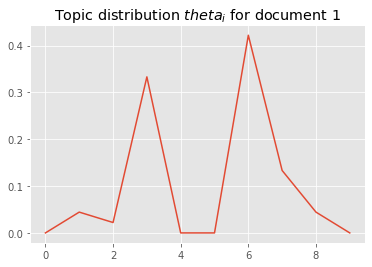

In [19]:
plt.plot(n_d_k[test]/ sum(n_d_k[test]))
plt.title(f'Topic distribution $theta_i$ for document {test}')

In [20]:
inv_vocabulary = {v: k for k, v in voc.items()}
n_top_words = 15

for topic_idx, topic in enumerate(v_k_w):
    message = f'Topic #{topic_idx}: '
    message += " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: don know think government db president just mr going people key chip like right encryption
Topic #1: don people god think just does like know believe good say way make time things
Topic #2: output air w7 ah uw gm printf 17 t7 oname mv hz lk chz stream
Topic #3: like just good don know think car ve time does way use really got need
Topic #4: people said jesus world armenian time say god did think don armenians jews children like
Topic #5: edu use file com window available using key information server program set like windows pub
Topic #6: 00 edu file use data drive program dos disk available image mail software pc information
Topic #7: just problem like know good 16 55 does 10 bit got windows time 14 32
Topic #8: team space 10 year game 11 12 play games season 15 new period 18 20
Topic #9: ax max g9v b8f a86 pl 145 1d9 0t 1t 3t bhj giz 75u 34u


## Gensim application

We now move onwards to implement high-level LDA algorithms using some of python's most well-known libraries. For a first application, let's use the same corpus we used in class 2, namely a set of news articles written between 2016 and 2020 by a handful of outlets.

Firstly, we will need some libraries to process our data, which we already bave seen in the past. NLTK will give us a complete set of stopwords as well as a stemmer.

In [51]:
# nltk
import nltk                                                             # Natural language Toolkit
from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords                                       # Importing stopwords

We will also import gensim and associated modules, a C-written library for topic modeling and building word embeddings.

In [52]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#### Get data, pre-process

In [53]:
basedir = Path(os.environ['SUMMER_SCHOOL']) / 'Day4'
datadir = basedir / 'data'
utildir = basedir / 'utils'
os.chdir(basedir)

In [54]:
COLS = [
    'date',
    'author',
    'title',
    'article',
    'section',
    'publication'
]

TYPES = {
    'date': str,
    'author': str,
    'title': str,
    'article': str,
    'section': str,
    'publication': str
}

In [55]:
main_df = pd.read_csv(
    datadir / 'reuters_news.csv',
    usecols=COLS,
    dtype=TYPES
)

In [56]:
print(main_df.shape)
main_df.head(2)

(25090, 6)


date      author                                              title  \
0  2019-12-12  Ian Ransom  Internationals inspired by video tips from '98...   
1  2017-04-07         NaN  BRIEF-Beijing Capital Development's Q1 contrac...   

                                             article      section publication  
0  MELBOURNE (Reuters) - Tiger Woods’ Presidents ...  sports news     Reuters  
1  April 7 (Reuters) - Beijing Capital Developmen...   financials     Reuters

In [57]:
# Pre-processing steps
remove_punct = str.maketrans('','','!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’—')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [58]:
# Pre-processing function
def normalize_text(doc):
    """Takes documents as input and outputs clean tokens"""
    
    lower      = doc.lower()                                             # all lower case
    nopunc     = lower.translate(remove_punct)                           # remove punctuation
    words      = nopunc.split()                                          # split into tokens
    nostop     = [w for w in words if w not in stop_words]               # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop]         # normalize numbers
    stem_text  = [stemmer.stem(w) for w in no_numbers]                   # stem each word
    
    
    return stem_text

In [59]:
main_df = main_df.copy()

main_df['preproc'] = (
    main_df['article']
    .astype(str)
    .progress_apply(lambda row: normalize_text(row))
)

main_df['preproc'] = [' '.join(word) for word in main_df['preproc']]

100%|███████████████████████████████████████████████████████████████████████████| 25090/25090 [01:24<00:00, 297.96it/s]


In [27]:
main_df.preproc.iloc[1]

'april # reuter beij capit develop co ltd say contract sale # billion yuan # million march q1 contract sale # percent yy # billion yuan sourc text chines bitly2nkofsw compani coverag # # chines yuan renminbi report hong kong newsroom'

In [60]:
texts = main_df.preproc.str.split().tolist()

In [61]:
print(texts[1][:50])

['april', '#', 'reuter', 'beij', 'capit', 'develop', 'co', 'ltd', 'say', 'contract', 'sale', '#', 'billion', 'yuan', '#', 'million', 'march', 'q1', 'contract', 'sale', '#', 'percent', 'yy', '#', 'billion', 'yuan', 'sourc', 'text', 'chines', 'bitly2nkofsw', 'compani', 'coverag', '#', '#', 'chines', 'yuan', 'renminbi', 'report', 'hong', 'kong', 'newsroom']


We may want to use n-grams rather than single words. Gensim's approach to identifying n-grams from lists of words follows Mikolov and coauthors (2013) [paper](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf), and estimate for each pair of words the following score:
$$
\operatorname{score}\left(w_{i}, w_{j}\right)=\frac{\operatorname{count}\left(w_{i} w_{j}\right)-\delta}{\operatorname{count}\left(w_{i}\right) \times \operatorname{count}\left(w_{j}\right)}
$$

In [62]:
# Creating bigrams, trigrams

# Compute scores and store n-gram combinations
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[texts], threshold=100)  

# Exports the trainer model = uses less RAM, faster processing. Model updates no longer possible
bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

In [63]:
bigram_model[['southwestern', 'provinc', 'house']]

['southwestern_provinc', 'house']

In [64]:
# Pass our text data through the models
texts_bigrams = [bigram_model[doc] for doc in texts]
texts_trigrams = [trigram_model[doc] for doc in texts]

In [65]:
# Create Gensim Dictionary
gen_dict = corpora.Dictionary(texts_trigrams)
texts = texts_trigrams
corpus = [gen_dict.doc2bow(item) for item in texts]

The last object represents the input to the LDA model. Gensim packs in nested lists tuples corresponding to each word's given index in a document and its document-specific frequency. The actual word can be retreived by indexing from <code>gen_dict</code>, so that:

In [66]:
[[(gen_dict[i], freq) for i, freq in doc] for doc in corpus[1:2]]

[[('#', 7),
  ('report', 1),
  ('reuter', 1),
  ('april', 1),
  ('beij', 1),
  ('billion', 2),
  ('bitly2nkofsw', 1),
  ('capit', 1),
  ('chines', 2),
  ('co_ltd', 1),
  ('compani', 1),
  ('contract', 2),
  ('coverag', 1),
  ('develop', 1),
  ('hong_kong', 1),
  ('march', 1),
  ('million', 1),
  ('newsroom', 1),
  ('percent_yy', 1),
  ('q1', 1),
  ('sale', 2),
  ('say', 1),
  ('sourc_text', 1),
  ('yuan', 2),
  ('yuan_renminbi', 1)]]

### LDA model 

All we need to do now is actually call gensim's LDA model and feed it the processed corpus of text we obtained above. Gensim's main application of LDA uses variational inference, but the library also includes a wrapper for MALLET, a Java-based toolkit for NLP that includes a Gibbs Sampling LDA. We shall use this wrapper to approximate the posterior distribution and yield Bayesian estimates of the latent variables (in our example, topic compositions of a set of news articles).

In [67]:
os.environ.update({'MALLET_HOME': str(utildir / 'mallet-2.0.8')})
mallet_path = str(utildir / 'mallet-2.0.8' / 'bin' / 'mallet') 

In [68]:
from gensim.models.wrappers import LdaMallet

K = 20

ldamallet = LdaMallet(
   mallet_path, corpus=corpus, num_topics=K, id2word=gen_dict,
)

In [69]:
from pprint import pprint

pprint(ldamallet.show_topics(num_topics=20, formatted=True))

[(0,
  '0.023*"tax" + 0.020*"plan" + 0.018*"state" + 0.017*"govern" + '
  '0.016*"propos" + 0.010*"#" + 0.010*"fund" + 0.010*"pay" + 0.009*"program" + '
  '0.009*"cut"'),
 (1,
  '0.018*"peopl" + 0.013*"state" + 0.007*"report" + 0.007*"famili" + '
  '0.007*"call" + 0.006*"citi" + 0.006*"show" + 0.006*"twitter" + '
  '0.006*"statement" + 0.005*"support"'),
 (2,
  '0.024*"report" + 0.024*"unit" + 0.022*"countri" + 0.021*"state" + '
  '0.018*"reuter" + 0.017*"deal" + 0.016*"russia" + 0.015*"edit" + '
  '0.013*"meet" + 0.012*"agreement"'),
 (3,
  '0.196*"#" + 0.034*"point" + 0.022*"game" + 0.019*"score" + 0.012*"goal" + '
  '0.012*"assist" + 0.011*"season" + 0.010*"lead" + 0.009*"ad" + 0.008*"made"'),
 (4,
  '0.040*"trump" + 0.021*"campaign" + 0.020*"democrat" + 0.016*"elect" + '
  '0.012*"investig" + 0.011*"report" + 0.010*"presid" + 0.009*"parti" + '
  '0.009*"#" + 0.009*"state"'),
 (5,
  '0.024*"race" + 0.017*"team" + 0.014*"#" + 0.013*"year" + 0.012*"time" + '
  '0.010*"start" + 0.010*"

In [70]:
ldamallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In case you are wondering about the quality of our learnt topics, traditional applications of LDA use topic coherence to assess just how well topics are extracted from the data. The coherence score can be defined as:

$$
\text { CoherenceScore }=\sum_{i<j} \operatorname{score}\left(w_{i}, w_{j}\right)
$$

where $w_i$ and $w_j$ are the top words for a given topic. The score can then computed in one of several ways, and in this script we opt for CV (for a detailed explanation of $C_V$, see [here](https://ieeexplore.ieee.org/document/8259775). According to [Röder and coauthors](https://dl.acm.org/doi/10.1145/2684822.2685324), the $C_V$ measure is the most accurate of the lot, and is based on the _Pointwise Mutual Information_ score (PMI score). The PMI is defined as:

$$
\operatorname{PMI}\left(w_{i}, w_{j}\right)=\log \frac{P\left(w_{i}, w_{j}\right)+\epsilon}{P\left(w_{i}\right) P\left(w_{j}\right)}
$$

where $P(w_i)$ is the probability of finding the word $w_i$ in a random document of the trained model. $P(w_i, w_j)$ is the probability of finding both words $w_i$ and $w_j$ in a random document of the trained model.

Note that we could run a grid search of these measures of Coherence Score to draw an optimal number of topics. Here, we will just use CS to compare LDA with Gibbs Sampling vs. LDA with Variational inference, but the former is left as an exercise.


In [39]:
coherence_lda = CoherenceModel(model=ldamallet, texts=texts, dictionary=gen_dict, coherence='c_v')
coherence_lda = coherence_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.567759546155304


#### Variational inference
In case you attempted to run the above, you'll notice that it both (i) takes a while to complete and (ii) is very CPU demanding. This is the reason why most statistical NLP packages resort to variational inference when approximating the posterior. There is, however, a trade-off with how well the model performs. Gensim's application of VI reads as follows:

In [40]:
# Number of topics
K = 20

# LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus, # stream of document vectors
    id2word=gen_dict, # Mapping from word IDs to words
    num_topics= K, # Number of pre-defined topics
    random_state = 42, # For reproducibility
    update_every=10, # Number of documents to be iterated through for each update
    chunksize=1000,
    passes=2,
    alpha='symmetric', # try 'auto' to allow gensim to learn alpha
    per_word_topics=True
)

In [41]:
coherence_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=gen_dict, coherence='c_v')
coherence_lda = coherence_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3679521873381978


### Per article topic

In [72]:
topic_list = [sorted(article, key=lambda x: (x[1]), reverse=True)[0][0] for article in ldamallet[corpus]]

topic_keywords = {}

for topic in range(K):
    keyswds = ldamallet.show_topic(topic)
    keyswds = ", ".join([word for word, _ in keyswds])
    topic_keywords[topic] = keyswds

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
topic_keywords

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: 'tax, plan, state, govern, propos, #, fund, pay, program, cut',
 1: 'peopl, state, report, famili, call, citi, show, twitter, statement, support',
 2: 'report, unit, countri, state, reuter, deal, russia, edit, meet, agreement',
 3: '#, point, game, score, goal, assist, season, lead, ad, made',
 4: 'trump, campaign, democrat, elect, investig, report, presid, parti, #, state',
 5: 'race, team, #, year, time, start, edit, reuter, report, driver',
 6: '#, million, reuter, compani, billion, year, euro, coverag, sourc_text, share',
 7: '#, percent, year, expect, quarter, billion, analyst, share, report, price',
 8: 'olymp, #, world, game, sport, athlet, reuter, event, report, edit',
 9: 'year, time, posit, make, chang, mani, long, back, recent, manag',
 10: 'rule, court, report, case, govern, law, inform, feder, facebook, order',
 11: 'player, play, team, open, win, day, back, good, world_cup, final',
 12: '#, oil, price, crude, million, product, market, barrel, month, bpd',
 13: 'china,

In [75]:
main_df['topic'] = topic_list
main_df['topic_kwds'] = main_df['topic'].map(topic_keywords)

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Articles per topic

In [76]:
(
    main_df
    .groupby('topic')
    .article
    .count()
)

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic
0      781
1      758
2     1145
3      526
4     1509
5      821
6     2918
7     1280
8     1157
9      112
10    1231
11    1090
12    1313
13    1494
14    1819
15     910
16    1656
17     809
18    1675
19    2086
Name: article, dtype: int64

### Word counts per topic

In [77]:
main_df['article'] = main_df.article.astype(str)
main_df['word_len'] = main_df.article.str.split().str.len()

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


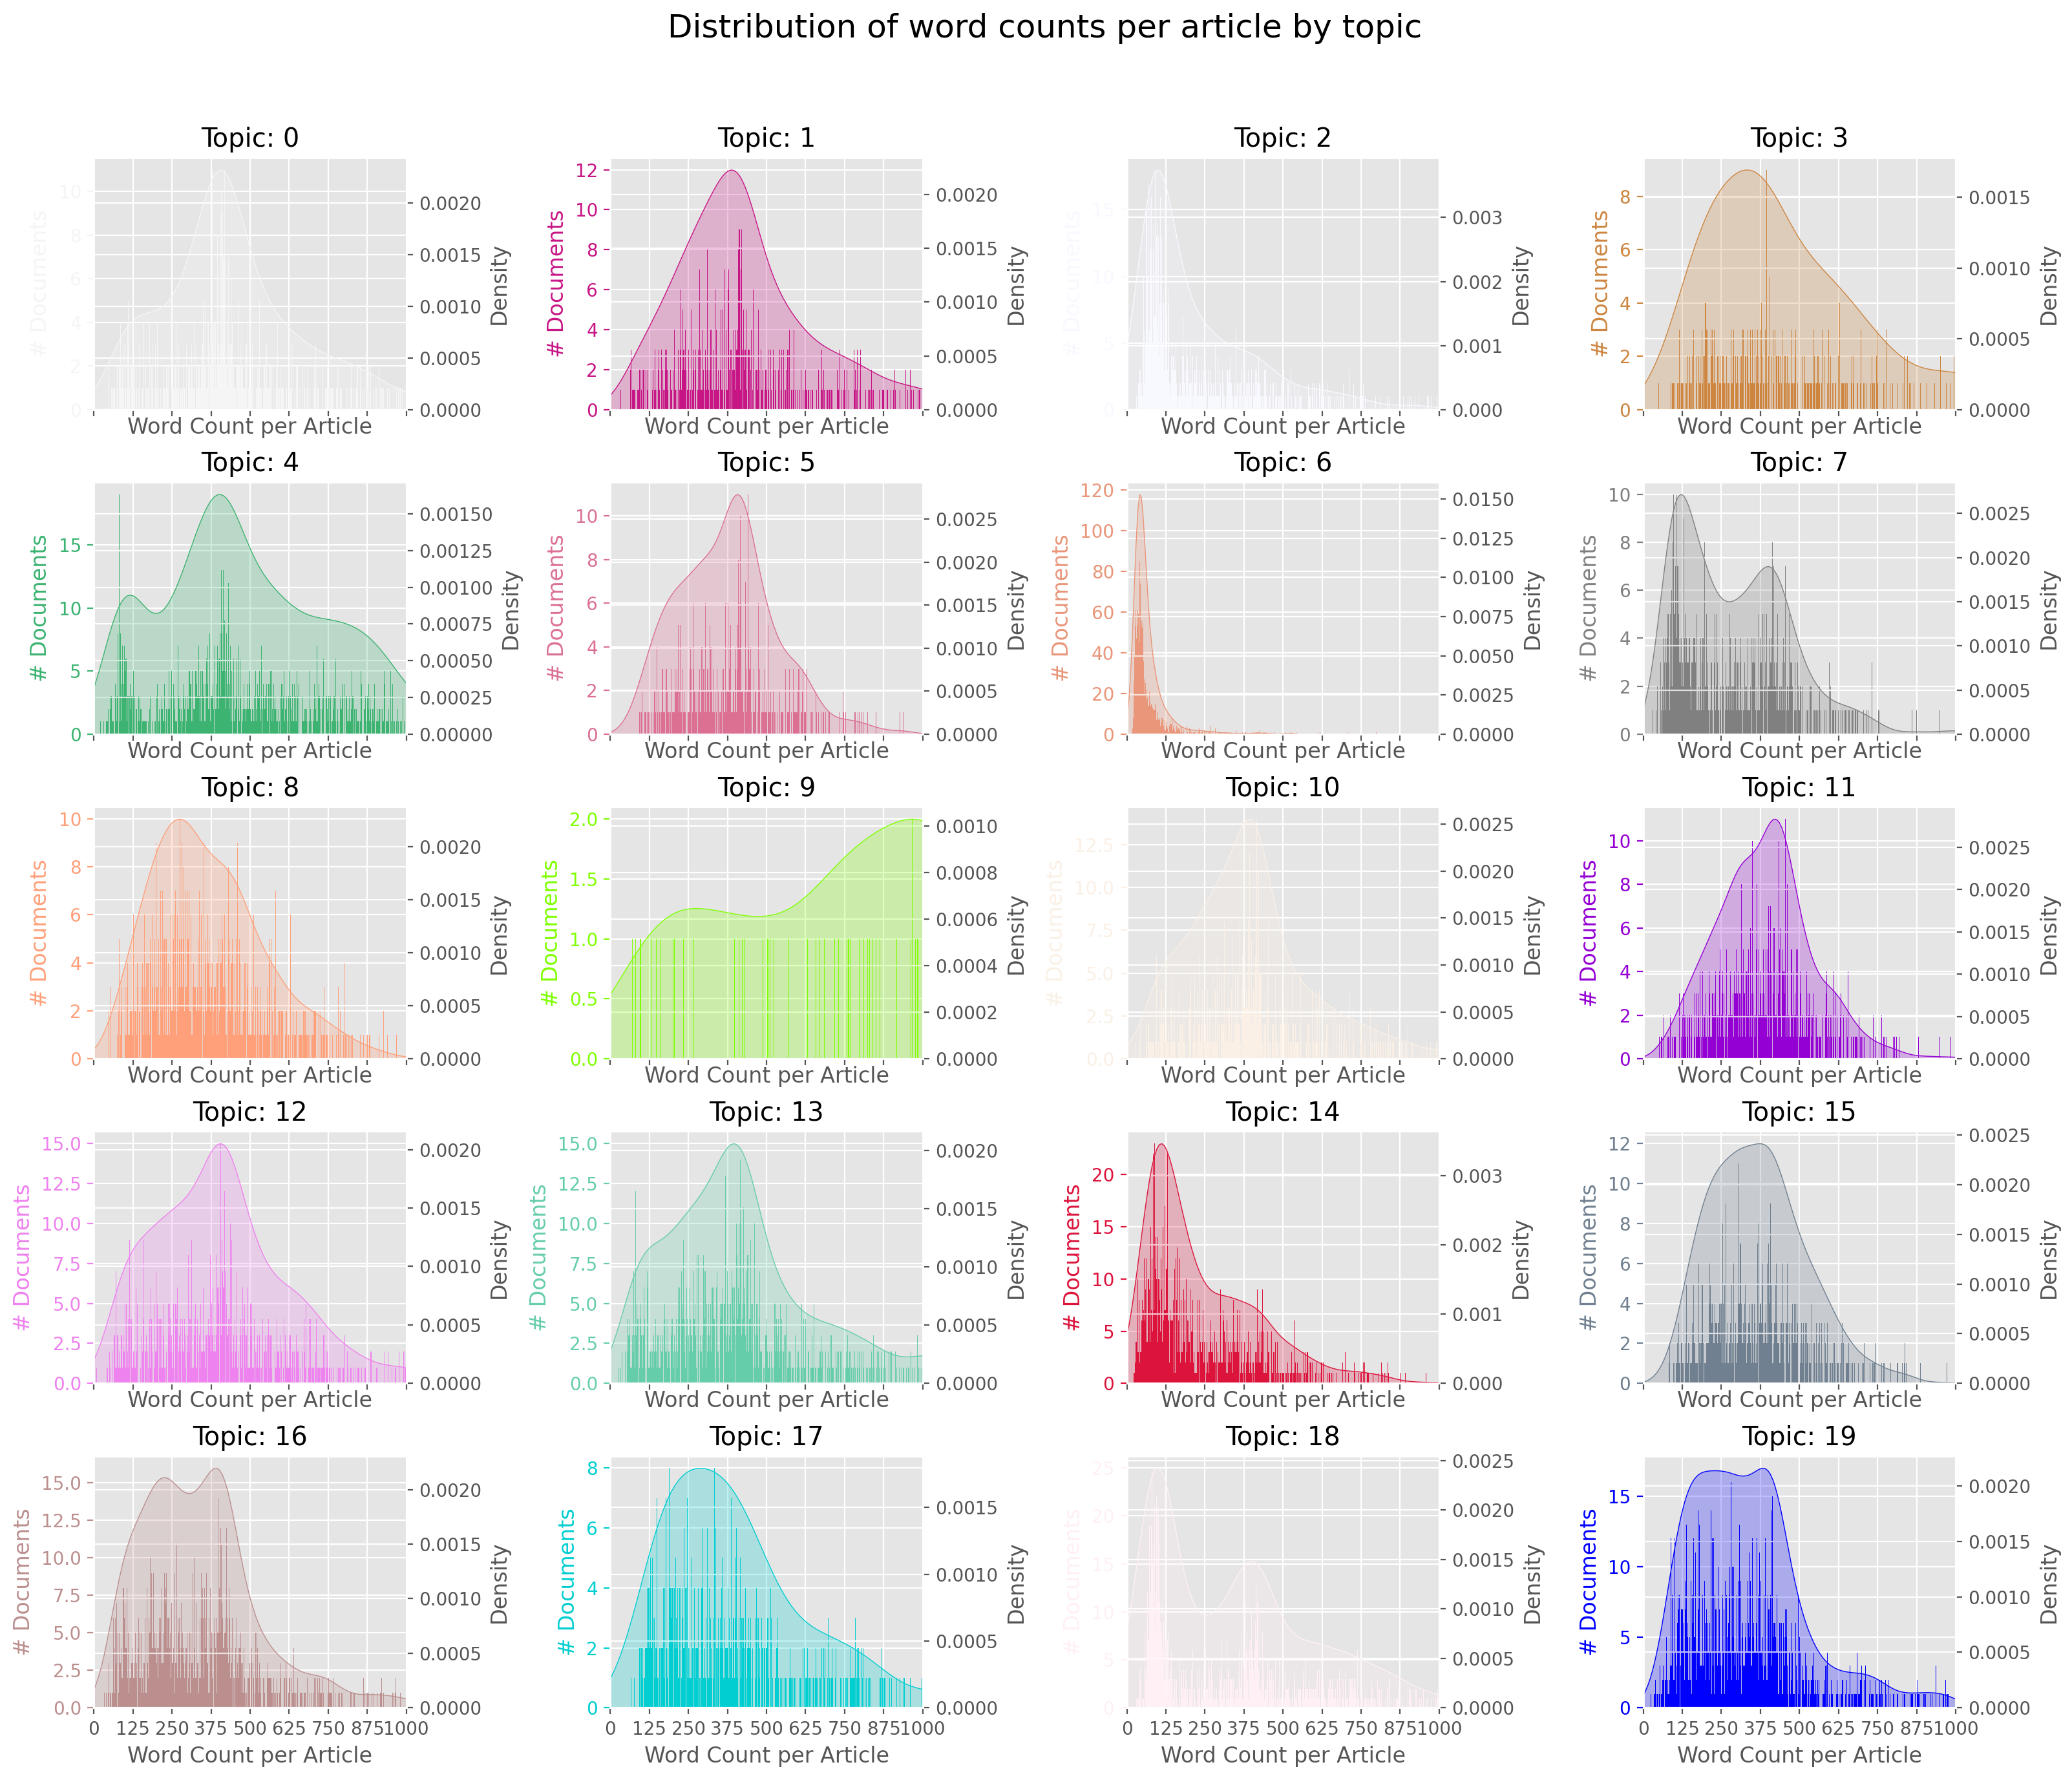

In [78]:
fig, axes = plt.subplots(5, 4,figsize=(16,14), dpi=200, sharex=True, sharey=False)

import matplotlib.colors as mcolors
import seaborn as sns
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

for i, ax in enumerate(axes.flatten()):
    choice = random.choice(list(colors.keys()))
    subset = main_df.loc[main_df.topic == i]
    ax.set_title('Topic: ' + str(i))
    ax.hist(data=subset, x="word_len", bins = 1000, color=colors[choice])
    ax.tick_params(axis='y', labelcolor=colors[choice], color=colors[choice])
    
    sns.kdeplot(data=subset, x="word_len", color=colors[choice], shade=True, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Word Count per Article')
    ax.set_ylabel('# Documents', color=colors[choice])

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of word counts per article by topic', fontsize=18)
plt.show()

In [79]:
topic_keywords = {}

for topic in range(K):
    keyswds = ldamallet.get_topic_terms(topicid=topic, topn=500)
    keyswds = {gen_dict[w_id]: freq for w_id, freq in keyswds}
    topic_keywords[topic] = keyswds

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


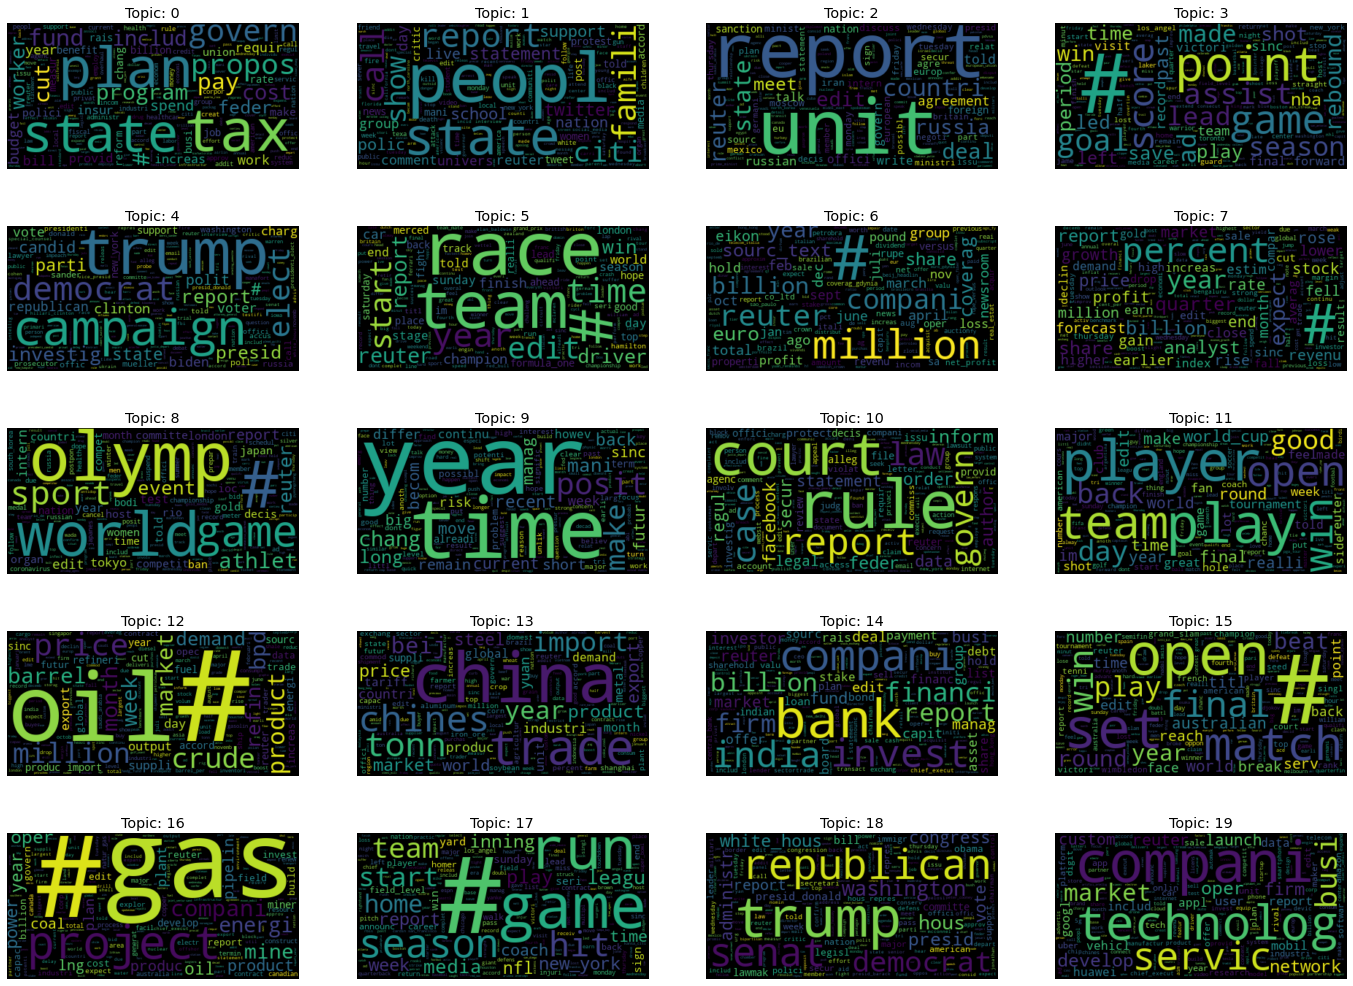

In [80]:
from wordcloud import WordCloud

fig, axes = plt.subplots(5, 4,figsize=(24,18))

for i, ax in enumerate(axes.flatten()):
    ax.set_title('Topic: ' + str(i))
    wordcloud = WordCloud().generate_from_frequencies(topic_keywords[i])

    # Plot resulting WordCloud
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.axis('off')

### Topic prediction example

In [81]:
unseen_text = 'The season of fourth-quarter earnings reports has begun and already companies are beating expectations. But that\'s not necessarily good news for stocks, as those expectations are very low. Wall Street slashed profit estimates over the last three months as the index lost 6.8 percent. The consensus estimate for fourth quarter S&P 500 growth has fallen to 11.9 percent from 17.8 percent in September, data from FactSet shows. Preliminary earnings results are already showing earnings beats, RBC Capital Markets strategist Lori Calvasina said in a note to investors on Tuesday. But those better-than-expected results represent companies stepping over a very low bar. \"The tone around demand and the underlying backdrop has rattled US equity investors,\" Calvasina said. Apple confirmed what many feared when it announced lowered revenue guidance for the upcoming quarter. Even if Apple were to beat expectations, the damage to the stock was done earlier this month following the lowered guidance. Morgan Stanley strategist Michael Wilson said he expects more \"Apple-like price reactions to guidance cuts\" when companies report. \"We would expect negative guidance revisions to be a persistent theme during 4Q earnings season,\" Wilson said. Even with the diminished expectations, Bank of America Merrill Lynch\'s Savita Subramanian said instances of companies beating expectations will be smaller and fewer. Her analysis shows that even the slashed estimates may not be enough, as Subramanian said "more estimate cuts are likely" for fourth quarter profits.'

# Preprocessing steps
normalized_unseen = normalize_text(unseen_text)

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
# Parse it into gensim dictionary
gen_dict_unseen = gen_dict.doc2bow(normalized_unseen)

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


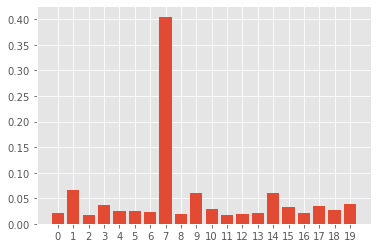

In [87]:
# Get topic probability distribution for a document
vector = ldamallet[gen_dict_unseen]

# Plot topic probabilities
plt.bar(*zip(*vector))
_=plt.xticks(np.arange(0, 20, 1.0))

### Document clustering

In [49]:
from sklearn.manifold import TSNE

In [50]:
def padding_topics(tup_lst):
    topic_list = []
    for i in range(20):
        f = 0
        for s, w in tup_lst:
            if s == i:
                topic_list.append(w)
                f=1
        if f==0:
            topic_list.append(0)
    return topic_list

In [51]:
topic_weights = []
for row_list in ldamallet[corpus]:
    topic_weights.append(padding_topics(row_list))

In [52]:
topic_weights = np.array(topic_weights)

In [53]:
# topic number in each doc
topic_num = np.argmax(topic_weights, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2,
                  verbose=1, random_state=42, angle=.99, 
                  init='pca'
                 )
tsne_lda = tsne_model.fit_transform(topic_weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25090 samples in 0.139s...
[t-SNE] Computed neighbors for 25090 samples in 21.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25090
[t-SNE] Computed conditional probabilities for sample 2000 / 25090
[t-SNE] Computed conditional probabilities for sample 3000 / 25090
[t-SNE] Computed conditional probabilities for sample 4000 / 25090
[t-SNE] Computed conditional probabilities for sample 5000 / 25090
[t-SNE] Computed conditional probabilities for sample 6000 / 25090
[t-SNE] Computed conditional probabilities for sample 7000 / 25090
[t-SNE] Computed conditional probabilities for sample 8000 / 25090
[t-SNE] Computed conditional probabilities for sample 9000 / 25090
[t-SNE] Computed conditional probabilities for sample 10000 / 25090
[t-SNE] Computed conditional probabilities for sample 11000 / 25090
[t-SNE] Computed conditional probabilities for sample 12000 / 25090
[t-SNE] Computed conditional probabilities for sa

In [54]:
colors = [color for _, color in list(mcolors.CSS4_COLORS.items())[:20]]
colors = [colors[i] for i in topic_num]

In [55]:
color_leg = list(dict.fromkeys(colors))
topic_leg = list(dict.fromkeys(topic_num))

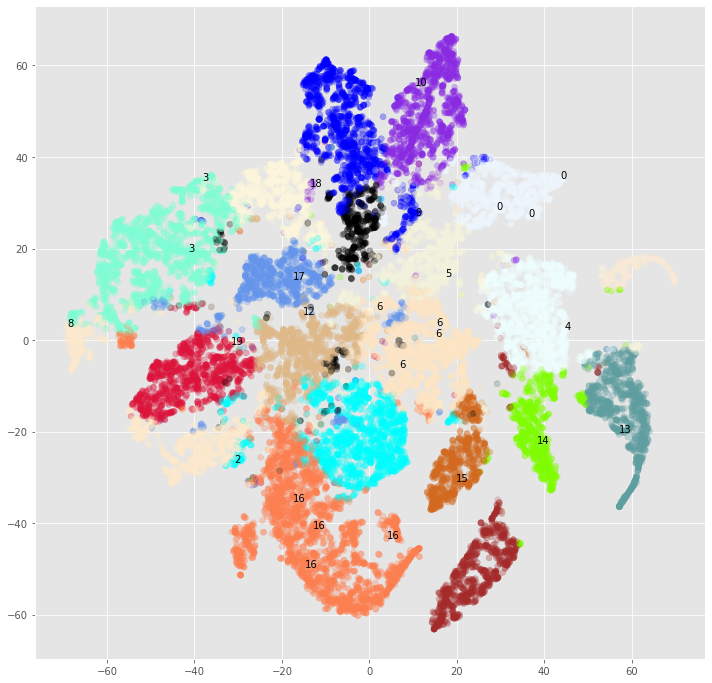

In [56]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(tsne_lda[:, 0], tsne_lda[:, 1], alpha=0.3, color=colors)

for i, pos in enumerate(tsne_lda):
    if i % 1000 == 0:
        ax.annotate(topic_num[i], pos)

# Application - FOMC Transcripts and Text Analysis

This last section presents some of the text analysis performed in the QJE's paper written by Stephen Hansen, Michael McMahon and Andrea Prat and published in 2018. A link to the article can be found [here](https://www.federalreserve.gov/monetarypolicy/fomc_historical_year.htm).

The paper analyzes how making the Federal Reserve monetary policy meetings more **transparent** affects policymakers' incentives and their between-peer discussions. The study is motivated by an ambiguous answer to that question, as theory highlights two potential channels through which transparency can affect performance:
- **Discipline**: Enhanced transparency may incentivize effort and relevant contributions
- **Conformity**: Enhanced transparency may discourage broad and creative debate

The authors exploit a change in the Federal Reserve's disclosure policy in 1993 to identify changes in behavior linked to the release of FOMC minutes data hitherto undisclosed. A simple natural experiment set-up with which authors are able to observe some interesting patterns:

- Inexperienced members show increased discipline and an enhanced focus on quantitative subjects when discussing economic prospects
- These same members engage in conformity when discussing tangible policy actions
- Overall, the former effect seems to dominate

### Background

- The FOMC is the main policy body of the Federal Reserve System and meets eight times a year to draft monetary policy
- Although the meetings were recorded, prior to 1993 it was believed that these recordings where destroyed
- However, Greenspan 'discovered' in 1993 that these were first transcribed and only then destroyed
- Within months of the revelation, the Fed agreed to publish all past transcripts and to release any transcripts henceforth with a five-year lag

The data is presented and pre-processed here, but the application of topic modeling is left as a take-home exercise. In the spirit of the paper, try to run the LDAMallet algorithm in the text below, and see how different topics dominated talks at the FOMC over time and before-after cases of financial distress.

### Build dataframe

Including in this script is a list of years containing transcripts from all FOMC meetings. These are readily available [here](https://www.federalreserve.gov/monetarypolicy/fomc_historical_year.htm). In order to keep the focus of the class narrow, steps to scrape the webpage and the use of OCR to transform to txt format are omitted here, but I can provide the script upon request. 

In [88]:
hansendir = datadir / 'hansen'

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
# Fetch all paths where the transcripts are stored
dict_transcripts = {}                                                 # A dictionary to feed

for year in range(1982, 2008):
    
    transcripts = []                                                  # A list to feed
    
    pwd = str(hansendir) + '/data/' + str(year)                       # Update print working directories

    year_transcripts = os.walk(pwd)                                   # Walk into year-specific print working directory
    
    for item in year_transcripts:                                     # (Actually it only finds one per year)
        for file in item[2]:                                          # Iterate over individual files found in a given pwd
            transcripts.append(str(item[0]) + "/" + file)             # Append to dictionary
    dict_transcripts[str(year)] = transcripts                         # Feed list
    
transcript_list = []                                                  # A list to feed using dictionary

for item in dict_transcripts.values():                                # Iterate over dictionary
    transcript_list += item                                           # Add key and value to list
    
transcript_list = sorted(transcript_list)                             # Sort transcripts

print("Length of Documents:", len(transcript_list))

Length of Documents: 209


C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
# A look at the body of the first document
infile = open(transcript_list[0], encoding="utf8")                    # Built-in function to open txt files
text = infile.readlines()                                             # Return all lines as a list

text = [line.strip() for line in text]                                # Remove any spacing either side of each line
text = ' '.join(text)                                                 # Join lines using a space as separator

print(text[:5000])                                                    # Print

Meeting of the Federal Open Market Committee February 1-2, 1982  A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D. C., starting on Monday, February 1, 1982, at 2:30 p.m. and continuing on Tuesday, February 2, 1982, at 9:00 a.m. PRESENT:  Mr. Volcker, Chairman Mr. Solomon, Vice Chairman Mr. Boehne Mr. Boykin Mr. Corrigan Mr. Gramley Mr. Keehn Mr. Partee Mr. Rice Mr. Schultz Mrs. Teeters Mr. Wallich Messrs. Balles, Black, Ford, Timlen, and Winn, Alternate Members of the Federal Open Market Committee Messrs. Guffey, Morris, 1/ and Roos, Presidents of the Federal Reserve Banks of Kansas City, Boston, and St. Louis, respectively Mr. Axilrod, Staff Director Mr. Altmann, Secretary Mr. Bernard, Assistant Secretary Mrs. Steele, Deputy Assistant Secretary Mr. Bradfield, General Counsel Mr. Mannion, Assistant General Counsel Mr. Kichline, Economist Messrs. Burns, Ettin, 2/ Mullineaux, Prell, Scheld, Tru

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
# Create large dataframe that splits statements and assigns author
appended_data = []                                                    # List to feed

for item in tqdm(transcript_list):

    infile = open(item, encoding="utf8")                              # Built-in function to open txt files
    text = infile.readlines()                                         # Return all lines as a list

    text = [line.strip() for line in text]                            # Remove any spacing either side of each line
    text = ' '.join(text)                                             # Join lines using a space as separator

    # Split text on any FOMC member being named using upper-case. Then store name and subsequent paragraph until next split
    splits=re.split('(?=MS. [A-Z]+.|MR. [A-Z]+.|CHAIRMAN [A-Z]+.|VICE CHAIRMAN [A-Z]+.|SPEAKER\(\?\))(MS. [A-Z]+.|MR. [A-Z]+.|CHAIRMAN [A-Z]+.|VICE CHAIRMAN [A-Z]+.|SPEAKER\(\?\))',text)
    
    dft=splits[1:-20]                                                 # Ignore first paragraph (intro) and end-document noise

    member, statement = dft[::2], dft[1::2]                           # Split in two lists (recall arguments [start:end:step])

    dft = list(zip(member, statement))                                # Join them again as tuples (member-statement pairs)

    dft = pd.DataFrame(dft,columns = ['member','statement'])          # Transform into a Pandas DataFrame
    dft['date'] = re.search('FOMC(\d+)meeting',item).group(1)         # Store the date of the meeting (using regex in file name)

    appended_data.append(dft)                                         # Append data to the list
    
appended_data = pd.concat(appended_data)                              # Concatenate all pandas DF stored in the list

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:13: DeprecationWarning: invalid escape sequence \(
<>:22: DeprecationWarning: invalid escape sequence \d
<>:13: DeprecationWarning: invalid escape sequence \(
<>:22: DeprecationWarning: invalid escape sequence \d
<ipython-input-102-c061fdda89ff>:13: DeprecationWarning: invalid escape sequence \(
  splits=re.split('(?=MS. [A-Z]+.|MR. [A-Z]+.|CHAIRMAN [A-Z]+.|VICE CHAIRMAN [A-Z]+.|SPEAKER\(\?\))(MS. [A-Z]+.|MR. [A-Z]+.|CHAIRMAN [A-Z]+.|VICE CHAIRMAN [A-Z]+.|SPEAKER\(\?\))',text)
<ipython-input-102-c061fdda89ff>:22: DeprecationWarning: invalid escape sequence \d
  dft['date'] = re.search('FOMC(\d+)meeting',item).grou

In [103]:
appended_data.head(20)

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


member                                          statement  \
0        CHAIRMAN VOLCKER.   Do we have any comments or questions on how t...   
1   VICE CHAIRMAN SOLOMON.   in most or all of these new wage agreements t...   
2              MR. ZEISEL.   Yes, it is apparently a fairly common part of...   
3        CHAIRMAN VOLCKER.   You have the line for compensation per hour g...   
4              MR. ZEISEL.   Well, it's not entirely in the future, but We...   
5        CHAIRMAN VOLCKER.   The Federal Reserve had a bigger increase in ...   
6              MR. ZEISEL.                                                      
7             MR. GRAMLEY.    Well, it's hard to know, but one can-The Fed...   
8              MR. ZEISEL.   The kinds of adjustments that President Solom...   
9        CHAIRMAN VOLCKER.   Yes, we see some signs of this, and some wage...   
10            MR. SCHULTZ.                                   I'm delighted.     
11       CHAIRMAN VOLCKER.             You'll have to explain that comment.     
12            MR. SCHULTZ.   Well, we do studies to see what the comparabl...   
13       CHAIRMAN VOLCKER.   They will be looking at ours and then we will...   
14             MR. ZEISEL.   You're perfectly right. In analyzing those in...   
15  VICE CHAIRMAN SOLOMON.   I'd like to offer a thesis. As I see the data...   
16             MR. ZEISEL.   That's generally true of wages as well. They ...   
17       CHAIRMAN VOLCKER.   They don't seem to operate very well in that ...   
18            MR. WALLICH.   Aren't we somewhat in a minority in regard to...   
19           MR. KICHLINE.   Well, I'm not sure. We have not examined We h...   

        date  
0   19820202  
1   19820202  
2   19820202  
3   19820202  
4   19820202  
5   19820202  
6   19820202  
7   19820202  
8   19820202  
9   19820202  
10  19820202  
11  19820202  
12  19820202  
13  19820202  
14  19820202  
15  19820202  
16  19820202  
17  19820202  
18  19820202  
19  19820202

### Checks

In [104]:
print('Size:', appended_data.shape)

# Duplicates, NAN
print('Duplicated entries:', appended_data.duplicated().any())
appended_data.head(5)

Size: (76080, 3)
Duplicated entries: True


C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


member                                          statement  \
0       CHAIRMAN VOLCKER.   Do we have any comments or questions on how t...   
1  VICE CHAIRMAN SOLOMON.   in most or all of these new wage agreements t...   
2             MR. ZEISEL.   Yes, it is apparently a fairly common part of...   
3       CHAIRMAN VOLCKER.   You have the line for compensation per hour g...   
4             MR. ZEISEL.   Well, it's not entirely in the future, but We...   

       date  
0  19820202  
1  19820202  
2  19820202  
3  19820202  
4  19820202

In [105]:
# Keep only rows with more than 50 characters
appended_data = appended_data.loc[appended_data['statement'].str.len() >=50].reset_index(drop = True)

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
print('Size:', appended_data.shape)

# Duplicates, NAN
print('Duplicated entries:', appended_data.duplicated().any())

Size: (50601, 3)
Duplicated entries: True


C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
# Number of duplicated entries
print('Number of duplicated entries:',len(appended_data.loc[appended_data.duplicated() == True]))

# Drop the two odd observations
appended_data = appended_data.loc[appended_data.duplicated() == False]

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of duplicated entries: 2


C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


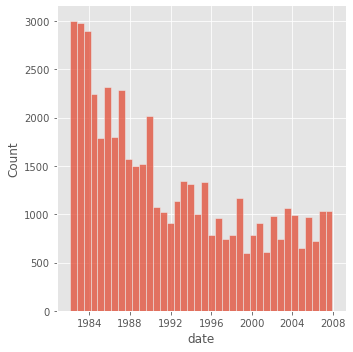

In [108]:
# Visualize distribution of statements - Create datetime column
appended_data['date'] = pd.to_datetime(appended_data['date'], format='%Y%m%d')

# Visualize distribution of statements - Histogram plot
sns.displot(appended_data, x="date")

## Text Pre-Processing

The script above fetched the data and appended it in a single, tractable dataframe. The next natural step in all text analysis applications is to pre-process the corpus of data. Note that, in order to streamline our text pre-processing tasks, we omit the part-of-speech tagger process described in section IV. B. In case you are interested, you can find a more detailed description [here](https://nlp.stanford.edu/pubs/tagging.pdf) and an NLTK implementation [here](http://www.nltk.org/book/ch05.html).

In [109]:
# Pre-processing steps
remove_punct = str.maketrans('','','!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’')
stop_words = stopwords.words('english')
stop_words.append('think')
stemmer      = SnowballStemmer('english')

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
# Pre-processing function
def normalize_text(doc):
    """Takes documents as input and outputs clean tokens"""
    
    doc        = doc.replace('</br>', ' ')
    lower      = doc.lower()                                             # all lower case
    nopunc     = lower.translate(remove_punct)                           # remove punctuation
    words      = nopunc.split()                                          # split into tokens
    nostop     = [w for w in words if w not in stop_words]               # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop]         # normalize numbers
    stem_text  = [stemmer.stem(w) for w in no_numbers]                   # stem each word
    
    return stem_text

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
# Pass all statements through the pre-processing function
statements = []                                                          # Create list to feed

for doc in tqdm(appended_data['statement']):                             # Iterate over statement-sized documents
    
    raw_wip = normalize_text(doc)                                        # Call in normalize_text function on doc
    statements.append(raw_wip)                                           # Append to list
    
statements_clean = [" ".join(item) for item in statements]               #Convert each string-list to an actual string
print(type(statements_clean), len(statements_clean))

# Create additional column in the speeches DF that is the pre-processed speeches
appended_data["preproc"] = statements_clean                     # Create column in DataFrame containing list

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|███████████████████████████████████████████████████████████████████████████| 50599/50599 [00:56<00:00, 889.09it/s]

<class 'list'> 50599


In [70]:
# Check a handful of rows in our pre-processed corpus
appended_data.head(10)

member                                          statement  \
0       CHAIRMAN VOLCKER.   Do we have any comments or questions on how t...   
1  VICE CHAIRMAN SOLOMON.   in most or all of these new wage agreements t...   
2             MR. ZEISEL.   Yes, it is apparently a fairly common part of...   
3       CHAIRMAN VOLCKER.   You have the line for compensation per hour g...   
4             MR. ZEISEL.   Well, it's not entirely in the future, but We...   
5       CHAIRMAN VOLCKER.   The Federal Reserve had a bigger increase in ...   
6            MR. GRAMLEY.    Well, it's hard to know, but one can-The Fed...   
7             MR. ZEISEL.   The kinds of adjustments that President Solom...   
8       CHAIRMAN VOLCKER.   Yes, we see some signs of this, and some wage...   
9            MR. SCHULTZ.   Well, we do studies to see what the comparabl...   

        date                                            preproc  
0 1982-02-02  comment question peopl see thing question unde...  
1 1982-02-02  new wage agreement come much lower level teams...  
2 1982-02-02  yes appar fair common part limit number agreem...  
3 1982-02-02  line compens per hour go pretti steepli futur ...  
4 1982-02-02  well entir futur your perfect right larg degre...  
5 1982-02-02  feder reserv bigger increas compens look forwa...  
6 1982-02-02  well hard know one canth feder reserv recess h...  
7 1982-02-02  kind adjust presid solomon mention minut ago s...  
8 1982-02-02  yes see sign wage agreement report newspap sug...  
9 1982-02-02  well studi see compar salari compar salari go ...

## LDA

In [71]:
hansen_texts = appended_data.preproc.str.split().tolist()

In [72]:
print(hansen_texts[1][:50])

['new', 'wage', 'agreement', 'come', 'much', 'lower', 'level', 'teamster', 'other', 'first', 'time', 'claus', 'indic', 'labor', 'reopen', 'contract', 'know', 'condit', 'improv', 'industri', 'extent', 'like', 'recoveri', 'start', 'bring', 'sharp', 'revers', 'downward', 'trend', 'labor', 'cost']


In [73]:
# Creating bigrams, trigrams

# Compute scores and store n-gram combinations
bigram_hansen = gensim.models.Phrases(hansen_texts, min_count=5, threshold=100)
trigram_hansen = gensim.models.Phrases(bigram[hansen_texts], threshold=100)  

# Exports the trainer model = uses less RAM, faster processing. Model updates no longer possible
bigram_model_hansen = gensim.models.phrases.Phraser(bigram_hansen)
trigram_model_hansen = gensim.models.phrases.Phraser(trigram_hansen)

In [74]:
# Pass our text data through the models
texts_bigrams_hansen = [bigram_model_hansen[doc] for doc in hansen_texts]
texts_trigrams_hansen = [trigram_model_hansen[doc] for doc in hansen_texts]

In [75]:
# Create Gensim Dictionary
gen_dict_hansen = corpora.Dictionary(texts_trigrams_hansen)
texts_hansen = texts_trigrams_hansen
corpus_hansen = [gen_dict_hansen.doc2bow(item) for item in texts_hansen]

In [76]:
import time

start= time.time()
ldahansen = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=corpus_hansen, num_topics=40, id2word=gen_dict_hansen
)
end = time.time()
elapsed = end - start
print(f'LDA GS converged, elapsed time: {elapsed}')

LDA GS converged, elapsed time: 186.4596972465515


In [77]:
ldahansen = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldahansen)

### Results

In [78]:
# Top result (dominant topic) and top words
topic_list_hansen = [sorted(statement, key=lambda x: (x[1]), reverse=True)[0][0] for statement in ldahansen[corpus_hansen]]

topic_keywords_hansen = {}

for topic in range(40):
    keyswds_hansen = ldahansen.show_topic(topic)
    keyswds_hansen = ", ".join([word for word, _ in keyswds_hansen])
    topic_keywords_hansen[topic] = keyswds_hansen

In [79]:
# All topic probabilities
dict_hansen = {i: dict(statement) for i, statement in enumerate(ldahansen[corpus_hansen])}

In [80]:
topics_df = pd.DataFrame.from_dict(
    {i: dict_hansen[i] 
    for i in dict_hansen.keys()
    },
    orient='index'
)

In [81]:
appended_data['topic'] = topic_list_hansen
appended_data['topic_kwds'] = appended_data['topic'].map(topic_keywords_hansen)

# Somewhere two rows are dropped, we reset index for merge below
appended_data.reset_index(drop=True, inplace=True)

appended_data = pd.merge(appended_data, topics_df, left_index=True, right_index=True)

In [82]:
for i in range(40):
    appended_data.rename(columns={i: 'Topic' + str(i)}, inplace=True)

In [83]:
appended_data.head(5)

member                                          statement  \
0       CHAIRMAN VOLCKER.   Do we have any comments or questions on how t...   
1  VICE CHAIRMAN SOLOMON.   in most or all of these new wage agreements t...   
2             MR. ZEISEL.   Yes, it is apparently a fairly common part of...   
3       CHAIRMAN VOLCKER.   You have the line for compensation per hour g...   
4             MR. ZEISEL.   Well, it's not entirely in the future, but We...   

        date                                            preproc  topic  \
0 1982-02-02  comment question peopl see thing question unde...     12   
1 1982-02-02  new wage agreement come much lower level teams...     30   
2 1982-02-02  yes appar fair common part limit number agreem...     30   
3 1982-02-02  line compens per hour go pretti steepli futur ...     30   
4 1982-02-02  well entir futur your perfect right larg degre...     30   

                                          topic_kwds    Topic0    Topic1  \
0  question, rais, issu, make, answer, differ, se...  0.022323  0.022321   
1  product, labor, increas, cost, growth, wage, m...  0.024708  0.018867   
2  product, labor, increas, cost, growth, wage, m...  0.029506  0.018535   
3  product, labor, increas, cost, growth, wage, m...  0.031912  0.021186   
4  product, labor, increas, cost, growth, wage, m...  0.011817  0.062370   

     Topic2    Topic3  ...   Topic30   Topic31   Topic32   Topic33   Topic34  \
0  0.022321  0.024196  ...  0.022321  0.022321  0.022492  0.022322  0.022321   
1  0.018511  0.017986  ...  0.078920  0.043806  0.030427  0.018512  0.026326   
2  0.032319  0.016509  ...  0.133435  0.018285  0.017372  0.019848  0.014360   
3  0.021186  0.027489  ...  0.055087  0.021186  0.023936  0.021534  0.021186   
4  0.028393  0.024921  ...  0.131692  0.037198  0.010510  0.013695  0.029130   

    Topic35   Topic36   Topic37   Topic38   Topic39  
0  0.022321  0.022608  0.029167  0.022321  0.022321  
1  0.019613  0.065371  0.016892  0.020089  0.021078  
2  0.012945  0.028312  0.011068  0.023717  0.034757  
3  0.021544  0.024102  0.021186  0.024565  0.022491  
4       NaN  0.026766       NaN  0.037487  0.017995  

[5 rows x 46 columns]

In [110]:
pprint(ldahansen.show_topics(num_topics=40, formatted=True))

[(0,
  '0.043*"spend" + 0.033*"invest" + 0.032*"busi" + 0.028*"consum" + '
  '0.028*"capit" + 0.026*"incom" + 0.026*"inventori" + 0.021*"stock" + '
  '0.015*"household" + 0.014*"sector"'),
 (1,
  '0.174*"forecast" + 0.064*"project" + 0.046*"greenbook" + 0.046*"year" + '
  '0.035*"growth" + 0.032*"staff" + 0.029*"gdp" + 0.024*"real" + 0.020*"revis" '
  '+ 0.019*"quarter"'),
 (2,
  '0.049*"model" + 0.038*"chang" + 0.031*"effect" + 0.021*"differ" + '
  '0.018*"relat" + 0.014*"structur" + 0.013*"adjust" + 0.013*"estim" + '
  '0.013*"base" + 0.012*"analysi"'),
 (3,
  '0.050*"problem" + 0.023*"world" + 0.021*"make" + 0.019*"view" + 0.019*"tri" '
  '+ 0.017*"believ" + 0.017*"deal" + 0.014*"polit" + 0.013*"good" + '
  '0.013*"work"'),
 (4,
  '0.116*"peopl" + 0.075*"lot" + 0.060*"thing" + 0.056*"dont" + 0.053*"talk" + '
  '0.044*"realli" + 0.030*"kind" + 0.027*"problem" + 0.024*"someth" + '
  '0.022*"happen"'),
 (5,
  '0.028*"district" + 0.028*"continu" + 0.027*"report" + 0.026*"nation" + '
  '

In [85]:
topic_keywords_hansen = {}

for topic in range(40):
    keyswds_hansen = ldahansen.get_topic_terms(topicid=topic, topn=500)
    keyswds_hansen = {gen_dict_hansen[w_id]: freq for w_id, freq in keyswds_hansen}
    topic_keywords_hansen[topic] = keyswds_hansen

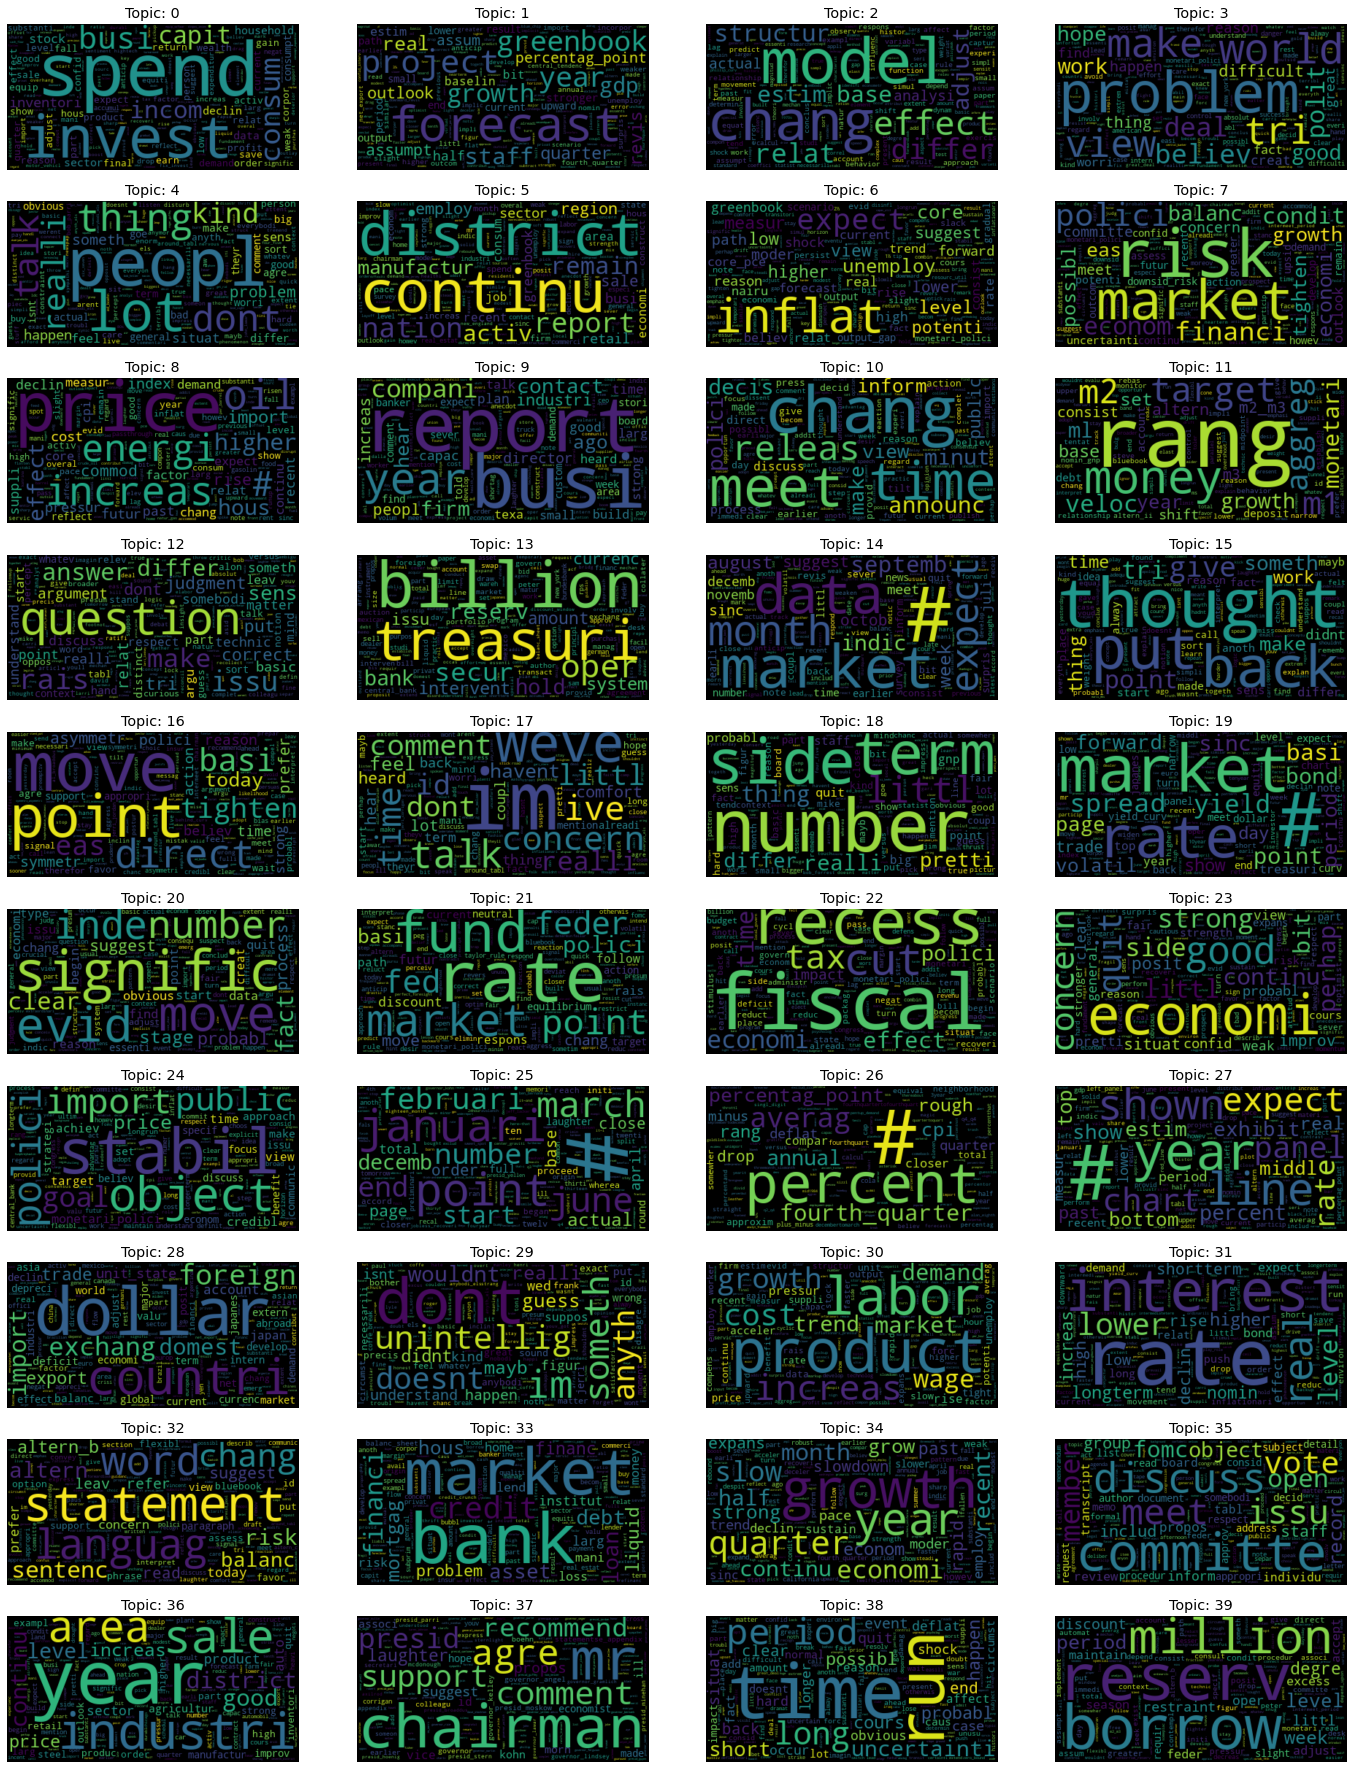

In [86]:
from wordcloud import WordCloud

fig, axes = plt.subplots(10, 4,figsize=(24,32))

for i, ax in enumerate(axes.flatten()):
    ax.set_title('Topic: ' + str(i))
    wordcloud = WordCloud().generate_from_frequencies(topic_keywords_hansen[i])

    # Plot resulting WordCloud
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.axis('off')

In [87]:
mpc_df = appended_data.groupby('date').mean().reset_index()
mpc_df.drop(columns='topic', axis=0, inplace=True)

Text(0, 0.5, "Fraction of speaker's time")

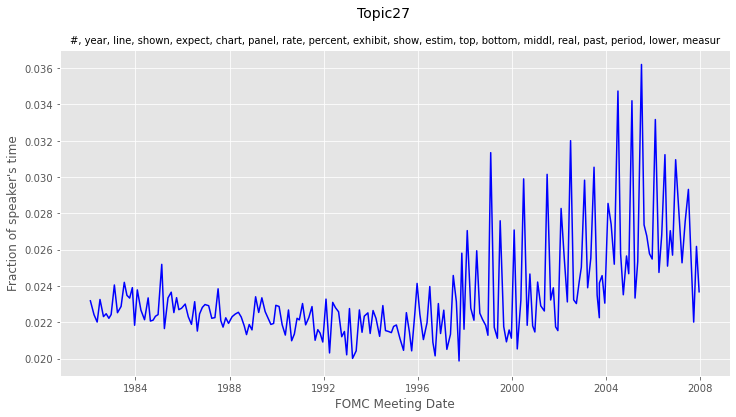

In [88]:
# Define topic to plot
choice_topic = 'Topic27'

# Retreive top words from chosen topic 
numeric = int(re.search('\d+', choice_topic).group(0))
top_words = list(topic_keywords_hansen[numeric].keys())[:20]

# Create topic-specific dataframe
plt_df = mpc_df[['date', choice_topic]]

# Plot topic over time
dates = plt_df['date'].to_list()
topic_mean = plt_df[choice_topic].to_list()

# Define figure
fig, ax = plt.subplots(1, 1, figsize=(12,6))
fig.suptitle(choice_topic, fontsize=14)
ax.set_title(', '.join(top_words), fontsize=10)

# plt.style.use('ggplot')
plt.plot(dates, topic_mean, c='blue', label='Mean')
plt.xlabel('FOMC Meeting Date')
plt.ylabel('Fraction of speaker\'s time')

#### 3-month rolling windows

In [89]:
# Create 3-m rolling averages of member x statement topic coverages
for i in np.arange(0,40):
    colname = 'Topic' + str(i) + '_RA'
    
    # Group observations by member and create column with a rolling avg
    appended_data[colname]=appended_data.groupby(['member', 'date'])['Topic'+str(i)].rolling(3).mean().reset_index(drop = True) 

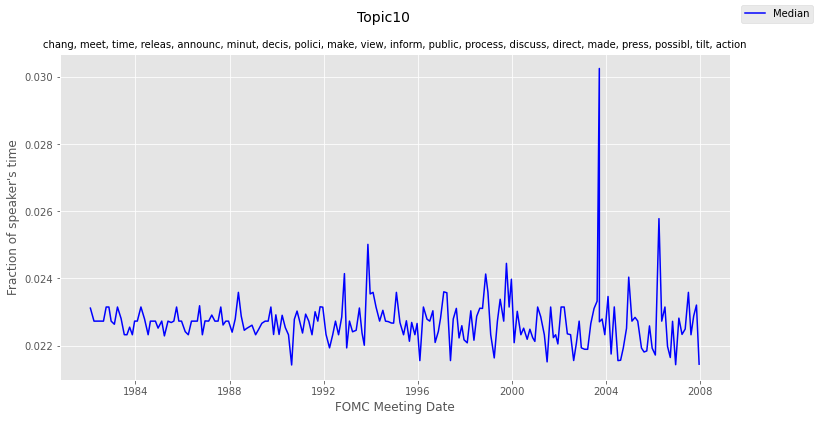

In [90]:
choice_topic = 'Topic10'

numeric = int(re.search('\d+', choice_topic).group(0))
top_words = list(topic_keywords_hansen[numeric].keys())[:20]

# Create topic-specific dataframe
plt_df=appended_data.groupby('date').agg({choice_topic: ['median']})
plt_df.columns = plt_df.columns.map('_'.join)
plt_df = plt_df.reset_index()

# Plot topic (Fig. III)
dates = plt_df['date'].to_list()
topic_median = plt_df[choice_topic + '_median'].to_list()

# Define figure
fig, ax = plt.subplots(1, 1, figsize=(12,6))
fig.suptitle(choice_topic, fontsize=14)
ax.set_title(', '.join(top_words), fontsize=10)


# plt.style.use('ggplot')
plt.plot(dates, topic_median, c='blue', label='Median')
plt.xlabel('FOMC Meeting Date')
plt.ylabel('Fraction of speaker\'s time')
ax.figure.legend()

### Member specific topic coverage

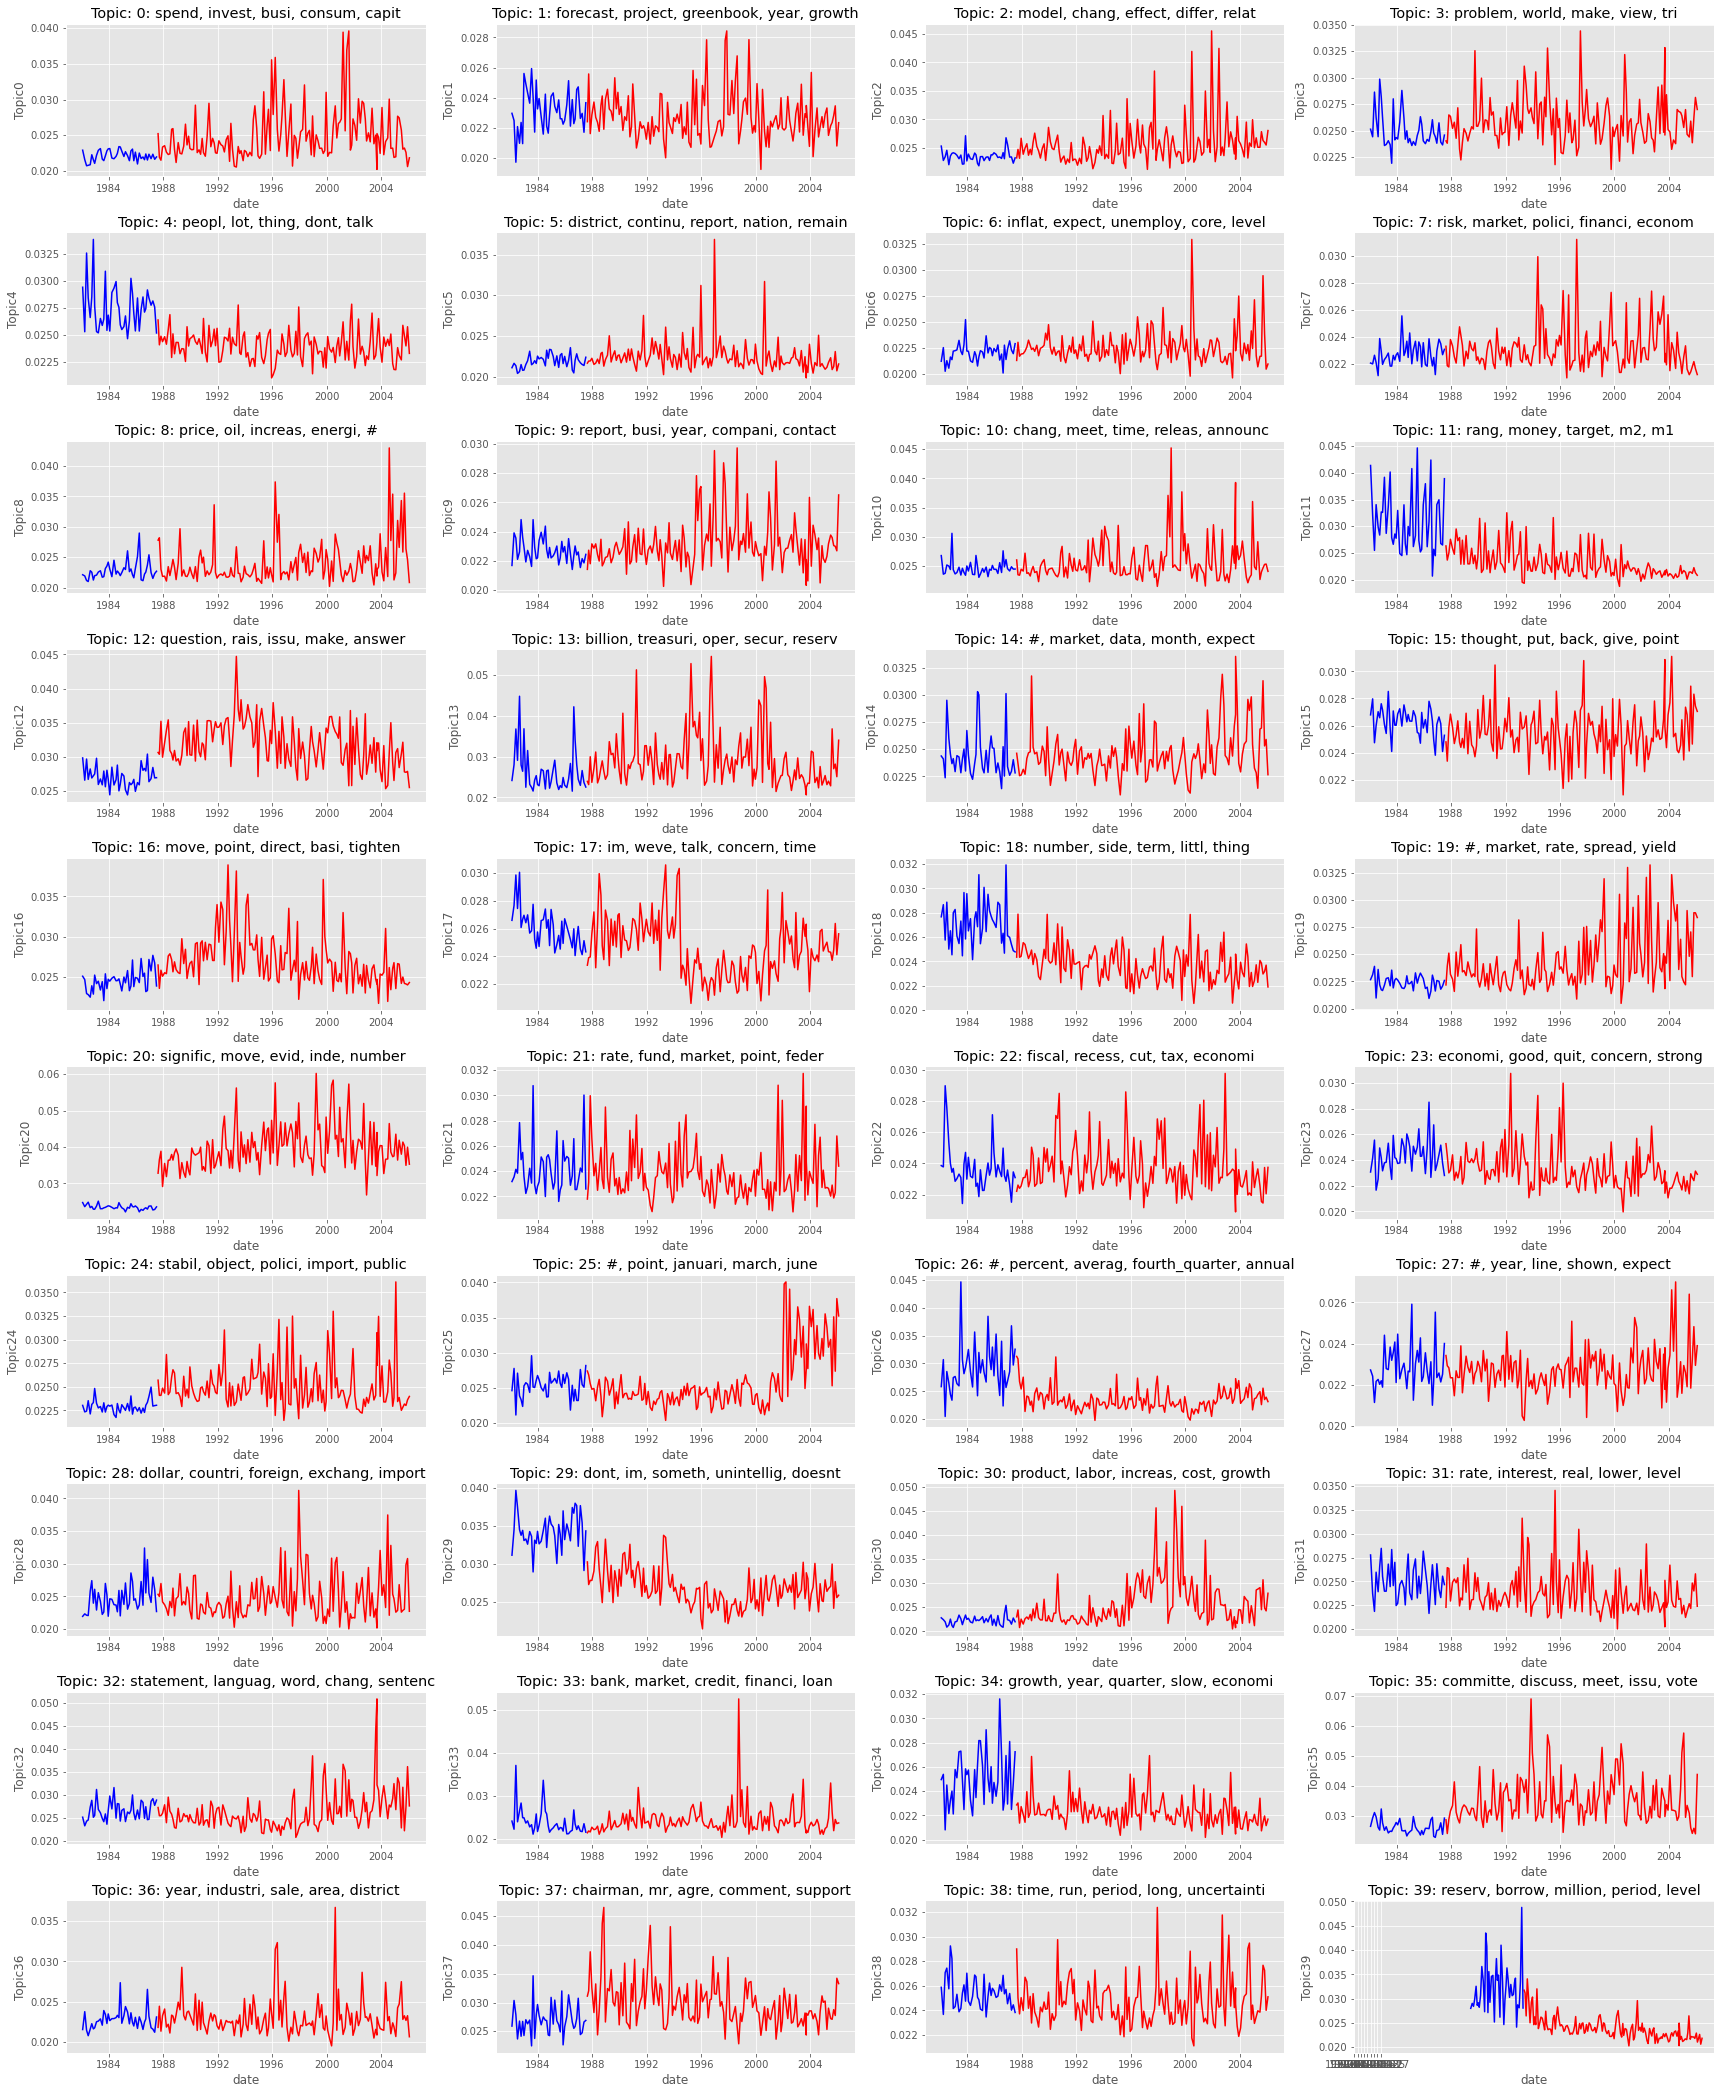

In [92]:
# Member-specific dataframe
plt_df_GS = appended_data.loc[appended_data.member=='CHAIRMAN GREENSPAN.']
plt_df_VK = appended_data.loc[appended_data.member=='CHAIRMAN VOLCKER.']

fig, axes = plt.subplots(10, 4,figsize=(24,32))

for i, axs in enumerate(axes.flatten()):
    
    topic_ = 'Topic' + str(i)
    top_words = list(topic_keywords_hansen[i].keys())[:5]
    
    subset_GS = plt_df_GS.groupby('date')[topic_].mean().reset_index()
    subset_VK = plt_df_VK.groupby('date')[topic_].mean().reset_index()
    
    sns.lineplot(data=subset_GS, x='date', color='r', y=topic_, ax = axs).set_title('Topic: ' + str(i) + ': ' + ', '.join(top_words))
    sns.lineplot(data=subset_VK, x='date', color='b', y=topic_, ax = axs)
    ax.set(xlabel='FOMC Meeting Date')
    ax.set_ylabel('Fraction on topic')
    

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
plt.show()


## Beyond: Apply LDA on transcripts data (requires web scraping)

https://seekingalpha.com/earnings/earnings-call-transcripts

#### Minimum working version of web scraper using requests and BS

In [112]:
import requests
from bs4 import BeautifulSoup

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [122]:
URL = r'https://www.fool.com/earnings/call-transcripts/2021/07/06/smart-global-holdings-inc-sgh-q3-2021-earnings-cal/'
# Request html response
response = requests.request('GET', URL)

# Parse response
soup = BeautifulSoup(response.content, 'lxml')

# Find text in html response
article = soup.find_all(lambda item: 'div' and item.has_attr('class') and item['class'] == ['full_article'])

# Extract paragraphs
earnings_text = []
for item in article:
    paragraphs = item.find_all('p')
    for i in paragraphs:
        earnings_text.append(i.text)

C:\Users\David\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Appendix - GIF creation (Dirichlet alphas)